In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [3]:

def readCaptions(CapPath):
    with open(CapPath) as f:
        captions = f.read()
    
    return captions

In [4]:
captions = readCaptions("Desktop/ML/flickr_8k_data/flicker8k_text/Flickr8k.token.txt")

In [5]:
captions = captions.split('\n')

In [125]:
captions = captions[:-1]

In [6]:
type(captions)

list

In [126]:
print(len(captions))

40460


In [127]:
print(captions[1])

1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .


In [128]:
capDict = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if capDict.get(img_name) is None:
        capDict[img_name] = []
    
    capDict[img_name].append(second)

In [129]:
capDict["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [130]:
def TextPreprocess(text):
    text = text.lower()
    text = re.sub("[^a-z]+"," ",text)
    
    text = text.split()
    
    text = [t for t in text if len(t)>1]
    text = " ".join(text)
    
    return text

In [131]:
for img,cap in capDict.items():
    for i in range(len(cap)):
        cap[i] = TextPreprocess(cap[i])

In [132]:
capDict["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [133]:
len(capDict)

8092

In [134]:
import cv2
import matplotlib.pyplot as plt
path = "Desktop/ML/flickr_8k_data/Flicker8k_Dataset/" 

In [135]:
##Saving Preprocessed Captions

In [136]:
with open("PreProcessedTxt1.txt","w") as f:
    f.write(str(capDict))

In [137]:
capDict = None 
with open("PreProcessedTxt.txt","r") as f:
    capDict = f.read()

json_acc_String = capDict.replace("'","\"")
capDict = json.loads(json_acc_String)

In [138]:
print(type(capDict))

<class 'dict'>


In [139]:
##Set is used to get all unique words
vocab = set()
for key in capDict.keys():
    [vocab.update(sentence.split()) for sentence in capDict[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [140]:
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 476706


In [141]:

import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

print(len(total_words))

9630
1900


In [142]:
img = cv2.imread(path+"1000268201_693b08cb0e.jpg")

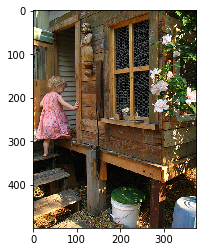

In [143]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [59]:

train_file_data = readCaptions("Desktop/ML/flickr_8k_data/flicker8k_text/Flickr_8k.trainImages.txt")
test_file_data = readCaptions("Desktop/ML/flickr_8k_data/flicker8k_text/Flickr_8k.testImages.txt")

In [76]:
trainSet = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
testSet = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [81]:
trainSet[0]

'2513260012_03d33305cf'

In [79]:
train_Captions = {}

for i in trainSet:
    train_Captions[i] = []
    for cap in capDict[i]:
        cap_appnd = "startseq "+cap+" endseq"
        train_Captions[i].append(cap_appnd)

In [82]:
train_Captions["2513260012_03d33305cf"]

['startseq black dog is running after white dog in the snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across the snowy ground endseq',
 'startseq two dogs play together in the snow endseq',
 'startseq two dogs running through low lying body of water endseq']

In [83]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [84]:
feat_Extrac_Model = Model(model.input,model.layers[-2].output)


In [ ]:
def preprocessImg(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img) 
    
    
    return img

In [86]:
def encode_image(img):
    img = preprocessImg(img)
    ResnetVector = feat_Extrac_Model.predict(img)
    ResnetVector = ResnetVector.reshape((-1,))
    
    return ResnetVector

In [87]:
encode_image(path+"1000268201_693b08cb0e.jpg")

array([0.04154316, 0.1707608 , 0.2927861 , ..., 0.05089623, 0.31322378,
       0.86007535], dtype=float32)

In [88]:

start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(trainSet):
    img_path = path+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [94]:
with open("Desktop/ML/flickr_8k_data/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [91]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(testSet):
    img_path = path+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Total Time Taken : 214.37582230567932


In [95]:
with open("Desktop/ML/flickr_8k_data/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [144]:
len(total_words)

1900

In [101]:
###captions preprocessing

In [155]:
word_2_idx = {}
idx_2_word = {}

for i,word in enumerate(total_words):
    word_2_idx[word] = i+1
    idx_2_word[i] = word

In [156]:
print(len(idx_2_word))

1900


In [157]:
##putting startseq and endseq 

In [162]:
idx_2_word[1901] = "startseq"
word_2_idx["startseq"] = 1901
idx_2_word[1902] = "endseq"
word_2_idx["endseq"] = 1902
vocab_size = len(word_2_idx)+1 

In [163]:
print(vocab_size)

1903


In [182]:
max_len = 0 
for key in train_Captions.keys():
    for cap in train_Captions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [160]:
###Data Generator

In [164]:
def data_generator(trainSet,encoding_train,word_2_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    
    
    n=0
    while True:
        for key,captions in trainSet.items():
            n+=1
            
            photo = encoding_train[key+".jpg"]
            for cap in captions:
                seq = [word_2_idx[word] for word in captions.split() if word in word_2_idx]
                
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post'[0])
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n == batch_size:
                    yield[[np.array(X1),np.array(X2)],np.array(y)]
                    

In [172]:
f = open("Desktop/ML/Datasets/glove.6B.50d.txt",encoding='utf8')

In [173]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [174]:
f.close()

In [175]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [176]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [177]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1903, 50)

In [178]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [183]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [2]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

NameError: name 'add' is not defined

In [185]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       95150       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [1]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

NameError: name 'model' is not defined